In [218]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from libs import nb_utils
from PIL import Image

print(tf.__version__)

1.13.1


In [219]:
class CPPN:
    def __init__(self, width=500, height=480, channels=1, latent_vector_flag=None, is_periodic=False, is_squared=False, hidden_neurons = 64, z_dim=8):
        self.width = width
        self.height = height
        self.channels = channels #RGB=3 or Greyscale=1
        self.latent_vector_flag = latent_vector_flag
        self.is_periodic = is_periodic
        self.is_squared = is_squared
        self.z_dim = z_dim
        self.hidden_neurons = hidden_neurons
        
    def create_inputs(self):
        
        t_x = tf.add(tf.div(tf.multiply(tf.range(0, self.width, dtype=tf.float32), 1.0), self.width), -0.5)
        t_x = tf.reshape(t_x, [1, self.width])
        if self.is_squared:
            t_x = tf.square(t_x)
        if self.is_periodic:
            t_x = tf.sin(tf.multiply(t_x, 50))
        t_x = tf.matmul(tf.ones([self.height, 1], tf.float32), t_x)
        t_x = tf.reshape(t_x, [self.height*self.width, 1])
        
        t_y = tf.add(tf.div(tf.multiply(tf.range(0, self.height, dtype=tf.float32), 1.0), self.height), -0.5)
        t_y = tf.reshape(t_y, [self.height, 1])
        if self.is_periodic:
            t_y = tf.sin(tf.multiply(t_y, 50))
        t_y = tf.matmul(t_y, tf.ones([1, self.width], tf.float32))
        t_y = tf.reshape(t_y, [self.height*self.width, 1])
        
        t_r = tf.sqrt(tf.square(t_x) + tf.square(t_y))
        t_r = tf.reshape(tf.transpose(t_r), [self.height*self.width, 1])
        
        t_z = None
        if self.latent_vector_flag is True:
            t_z = tf.random_uniform(shape=[1, self.z_dim], minval=-1.0, maxval=1.0, dtype=tf.float32)
            
        return [t_x, t_y, t_r, t_z] 
    
    def evaluate(self, input_t, output_size, activation, layer_num, add_bias=True):
        
        with tf.variable_scope("layer_"+layer_num):
            W_x = tf.get_variable('W_x', dtype=tf.float32, shape=[input_t.shape[1],output_size], initializer=tf.random_normal_initializer(mean=0.0, stddev=2.0, dtype=tf.float32))
            b_x = tf.get_variable('b_x', dtype=tf.float32, shape=[1, output_size], initializer=tf.random_normal_initializer(mean=0.0, stddev=2.0, dtype=tf.float32))

            if add_bias is True:
                return activation(tf.add(tf.matmul(input_t, W_x), b_x))
            else:
                return activation(tf.matmul(input_t, W_x))
        
    def generate(self):
        
        [t_x, t_y, t_r, t_z] = self.create_inputs()
        
        t_x = self.evaluate(t_x, output_size=self.hidden_neurons, activation=tf.tanh, layer_num='x_1', add_bias=True)
        t_y = self.evaluate(t_y, output_size=self.hidden_neurons, activation=tf.tanh, layer_num='y_1', add_bias=True)
        t_r = self.evaluate(t_r, output_size=self.hidden_neurons, activation=tf.tanh, layer_num='r_1', add_bias=True)
        if self.latent_vector_flag is True:
            t_z = self.evaluate(t_z, output_size=self.hidden_neurons, activation=tf.tanh, layer_num='z_1', add_bias=True)
        else:
            t_z = tf.zeros(shape=[1, self.hidden_neurons])
        output = t_x + t_y + t_r + t_z
        
        for i in range(2):
            output = self.evaluate(output, output_size=self.hidden_neurons, activation=tf.tanh, layer_num='hidden_'+str(i), add_bias=True)
        
        output = self.evaluate(output, output_size=self.channels, activation=tf.sigmoid, layer_num='output_'+str(i), add_bias=True)
        output = tf.dtypes.cast(output * 255.0, dtype=tf.uint8)
        output = tf.layers.flatten(output)
        output = tf.reshape(output, shape=[self.height, self.width, self.channels])
        return output

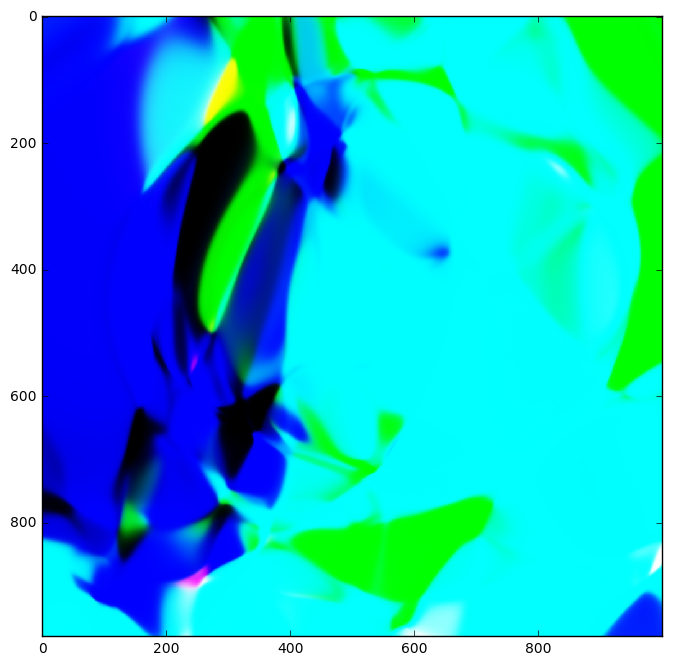

In [242]:
tf.reset_default_graph()
cppn = CPPN(width=1000, height=980, hidden_neurons=128, latent_vector_flag=True, channels=3)
with tf.Session() as sess:
    result = cppn.generate()
    sess.run(tf.global_variables_initializer())
    #nb_utils.show_graph(tf.get_default_graph().as_graph_def())
    fig=plt.figure(figsize=(8, 8))
    if cppn.channels is 3:
        plt.imshow(result.eval(), interpolation='nearest', aspect='auto')
    else:
        plt.imshow(tf.reshape(result,shape=[cppn.height, cppn.width]).eval(), cmap='gray', interpolation='nearest', aspect='auto')


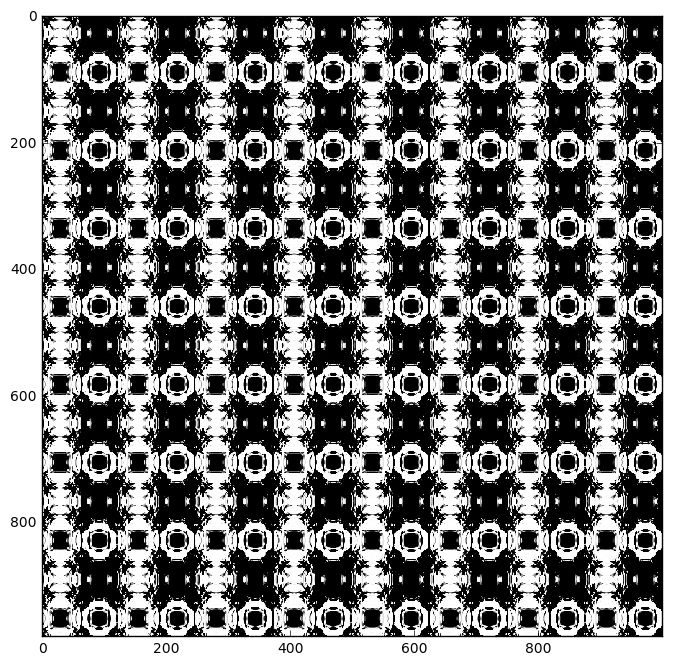

In [233]:
#
# Testing periodic inputs
#
tf.reset_default_graph()
cppn = CPPN(width=1000, height=980, hidden_neurons=128, latent_vector_flag=False, channels=1, is_periodic=True)
with tf.Session() as sess:
    result = cppn.generate()
    sess.run(tf.global_variables_initializer())
    fig=plt.figure(figsize=(8, 8))
    if cppn.channels is 3:
        plt.imshow(result.eval(), interpolation='nearest', aspect='auto')
    else:
        plt.imshow(tf.reshape(result,shape=[cppn.height, cppn.width]).eval(), cmap='gray', interpolation='nearest', aspect='auto')


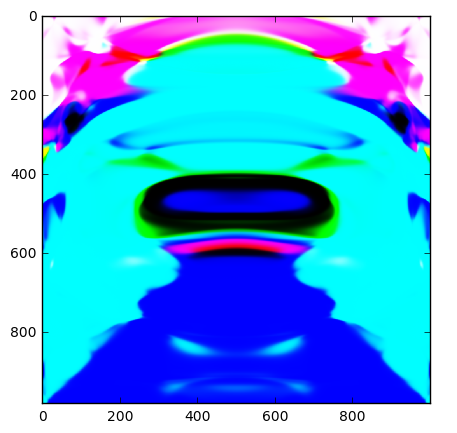

In [250]:
#
# Testing x-squared
#
tf.reset_default_graph()
cppn = CPPN(width=1000, height=980, hidden_neurons=128, latent_vector_flag=False, channels=3, is_periodic=False, is_squared=True)
with tf.Session() as sess:
    result = cppn.generate()
    sess.run(tf.global_variables_initializer())
    fig=plt.figure(figsize=(5, 5))
    if cppn.channels is 3:
        plt.imshow(result.eval(), interpolation='nearest', aspect='auto')
    else:
        plt.imshow(tf.reshape(result,shape=[cppn.height, cppn.width]).eval(), cmap='gray', interpolation='nearest', aspect='auto')
